In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

In [3]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [4]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 17)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']

                # Interpolar os dados bvp para o mesmo comprimento que eda e temp
                interpolação_bvp = interp1d(np.linspace(0, 1, len(bvp)), bvp)
                bvp_interp = interpolação_bvp(np.linspace(0, 1, len(eda)))

                interpolacao_label = interp1d(np.linspace(0, 1, len(label)), label)
                label_interp = interpolacao_label(np.linspace(0, 1, len(eda)))

                # Criar o array numpy combinando os sinais e os rótulos
                numpy_data = np.column_stack((bvp_interp, eda, temp, label_interp))
                
                # Adicionar os dados deste diretório à lista de todos os dados
                all_data.append(numpy_data)

# Converter a lista de arrays numpy em um único array numpy
combined_data = np.concatenate(all_data, axis=0)

In [5]:
column_names = ["bvp", "eda", "temp", "label"]

# Criar DataFrame
df = pd.DataFrame(data=combined_data, columns=column_names)

In [6]:
df

,bvp,eda,temp,label
0,-59.370000,1.138257,35.41,0.0
1,43.499827,1.125444,35.41,0.0
2,53.559753,1.011405,35.41,0.0
3,54.637650,1.033188,35.41,0.0
4,-117.945392,0.935807,35.41,0.0
...,...,...,...,...
323787,9.078561,0.384088,29.59,0.0
323788,8.158422,0.418632,29.57,0.0
323789,13.411865,0.405838,29.57,0.0
323790,-56.926510,0.409676,29.57,0.0


In [7]:
# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df= df[df['label'] != 0.0]

In [8]:
df

,bvp,eda,temp,label
1227,-21.310000,1.640539,35.81,1.0
1228,29.792745,1.634132,35.81,1.0
1229,48.794621,1.614912,35.81,1.0
1230,95.099143,1.591848,35.81,1.0
1231,-29.724324,1.558534,35.81,1.0
...,...,...,...,...
322908,8.681934,0.416073,29.81,4.0
322909,10.638678,0.416073,29.81,4.0
322910,-0.275001,0.417353,29.81,4.0
322911,-14.827703,0.414794,29.81,4.0


In [9]:
#df.to_csv('seu_dataframe.csv', index=False)

In [10]:
X = df.drop(columns=["label"])  # Remove a coluna "label" para obter os recursos
y = df["label"] # 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
y = y.astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9745828367103695


Temperatura

In [12]:
temp_min = []
temp_max = []
temp_mean = []

for i in range(0, len(df), 3):
    temps = df['temp'].iloc[i:i+3]
    temp_min.append(temps.min())
    temp_max.append(temps.max())
    temp_mean.append(temps.mean())

temp_stats = pd.DataFrame({'temp_min': temp_min, 'temp_max': temp_max, 'temp_mean': temp_mean})

In [13]:
temp_min_array = np.array(temp_stats['temp_min'])
normalized_temp_min = preprocessing.normalize([temp_min_array])
temp_max_array = np.array(temp_stats['temp_max'])
normalized_temp_max = preprocessing.normalize([temp_max_array])
temp_mean_array = np.array(temp_stats['temp_mean'])
normalized_temp_mean = preprocessing.normalize([temp_mean_array])


In [14]:
data_temp = {
    'normalized_temp_mean': normalized_temp_mean.flatten(),
    'normalized_temp_max': normalized_temp_max.flatten(),
    'normalized_temp_min': normalized_temp_min.flatten()
}

df_temp = pd.DataFrame(data_temp)
df_temp.head()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min
0,0.004619,0.004619,0.004620
1,0.004619,0.004619,0.004620
2,0.004619,0.004619,0.004620
3,0.004622,0.004622,0.004623
4,0.004622,0.004622,0.004623



EDA

In [15]:
eda_min = []
eda_max = []
eda_mean = []
for i in range(0, len(df), 3):
    eda = df['eda'].iloc[i:i+3]
    eda_min.append(eda.min())
    eda_max.append(eda.max())
    eda_mean.append(eda.mean())

eda_stats = pd.DataFrame({'eda_min': eda_min, 'eda_max': eda_max, 'eda_mean': eda_mean})

In [16]:
print(eda_stats.head())

    eda_min   eda_max  eda_mean
0  1.614912  1.640539  1.629861
1  1.558534  1.591848  1.570493
2  1.535470  1.616194  1.579035
3  1.558534  1.573910  1.566649
4  1.538032  1.550846  1.545293


In [17]:
eda_min_array = np.array(eda_stats['eda_min'])
normalized_eda_min = preprocessing.normalize([eda_min_array])
eda_max_array = np.array(eda_stats['eda_max'])
normalized_eda_max = preprocessing.normalize([eda_max_array])
eda_mean_array = np.array(eda_stats['eda_mean'])
normalized_eda_mean = preprocessing.normalize([eda_mean_array])


In [18]:
data_eda = {
    'normalized_eda_mean': normalized_eda_mean.flatten(),
    'normalized_eda_max': normalized_eda_max.flatten(),
    'normalized_eda_min': normalized_eda_min.flatten()
}

df_eda = pd.DataFrame(data_eda)
df_eda.head()

,normalized_eda_mean,normalized_eda_max,normalized_eda_min
0,0.002197,0.002203,0.002185
1,0.002117,0.002137,0.002109
2,0.002128,0.002170,0.002078
3,0.002112,0.002113,0.002109
4,0.002083,0.002082,0.002081


BVP

In [19]:
bvp_min = []
bvp_max = []
bvp_mean = []
for i in range(0, len(df), 3):
    bvp = df['bvp'].iloc[i:i+3]
    bvp_min.append(bvp.min())
    bvp_max.append(bvp.max())
    bvp_mean.append(bvp.mean())

bvp_stats = pd.DataFrame({'bvp_min': bvp_min, 'bvp_max': bvp_max, 'bvp_mean': bvp_mean})

bvp_min_array = np.array(bvp_stats['bvp_min'])
normalized_bvp_min = preprocessing.normalize([bvp_min_array])
bvp_max_array = np.array(bvp_stats['bvp_max'])
normalized_bvp_max = preprocessing.normalize([bvp_max_array])
bvp_mean_array = np.array(bvp_stats['bvp_mean'])
normalized_bvp_mean = preprocessing.normalize([bvp_mean_array])

In [20]:
data_bvp = {
    'normalized_bvp_mean': normalized_bvp_mean.flatten(),
    'normalized_bvp_max': normalized_bvp_max.flatten(),
    'normalized_bvp_min': normalized_bvp_min.flatten()
}

df_bvp = pd.DataFrame(data_bvp)
df_bvp.head()

,normalized_bvp_mean,normalized_bvp_max,normalized_bvp_min
0,0.002649,0.003266,-0.001288
1,-0.000230,0.006366,-0.004250
2,0.009050,0.010767,-0.000514
3,-0.007889,-0.001093,-0.008000
4,-0.000027,0.003918,-0.002573


In [21]:
df_normalizado = pd.concat([df_temp, df_eda, df_bvp], axis=1)
df_normalizado.head()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_bvp_mean,normalized_bvp_max,normalized_bvp_min
0,0.004619,0.004619,0.004620,0.002197,0.002203,0.002185,0.002649,0.003266,-0.001288
1,0.004619,0.004619,0.004620,0.002117,0.002137,0.002109,-0.000230,0.006366,-0.004250
2,0.004619,0.004619,0.004620,0.002128,0.002170,0.002078,0.009050,0.010767,-0.000514
3,0.004622,0.004622,0.004623,0.002112,0.002113,0.002109,-0.007889,-0.001093,-0.008000
4,0.004622,0.004622,0.004623,0.002083,0.002082,0.002081,-0.000027,0.003918,-0.002573


In [22]:
df_normalizado.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_bvp_mean,normalized_bvp_max,normalized_bvp_min
55927,0.003845,0.003845,0.003846,0.000560,0.000560,0.000558,-0.000012,0.000817,-0.000779
55928,0.003845,0.003845,0.003846,0.000563,0.000560,0.000565,-0.001226,0.000570,-0.001667
55929,0.003843,0.003842,0.003843,0.000560,0.000560,0.000561,0.001048,0.000837,0.000024
55930,0.003845,0.003845,0.003843,0.000560,0.000559,0.000561,0.000048,0.000712,-0.001104
55931,0.003845,0.003845,0.003846,0.000561,0.000560,0.000561,-0.000436,0.000379,-0.000896


Random Forest

In [26]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})
label_stats.head()

,label_mean
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [28]:
label_stats.tail()

,label_mean
55927,4.0
55928,4.0
55929,4.0
55930,4.0
55931,4.0


In [30]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_set, labels, random_state=0)

In [31]:
# acurácia do rf
clf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

C:\Users\luiza\AppData\Local\Temp\ipykernel_8620\1834918725.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.9831938782807695

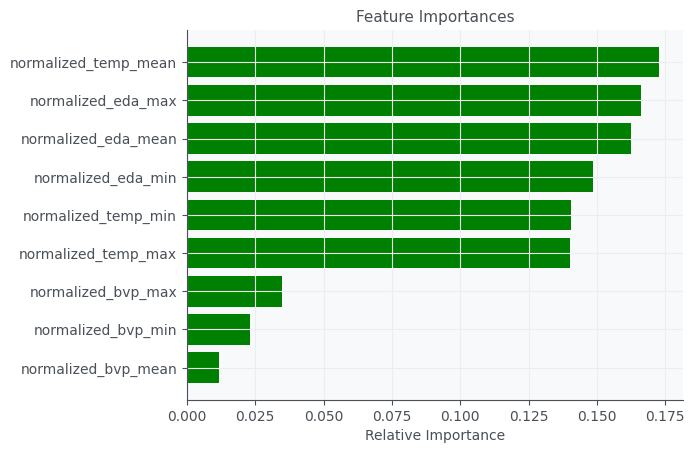

In [32]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature Importances')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

C:\Users\luiza\AppData\Local\Temp\ipykernel_8620\1361052437.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
C:\Users\luiza\AppData\Local\Temp\ipykernel_8620\1361052437.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
C:\Users\luiza\AppData\Local\Temp\ipykernel_8620\1361052437.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
C:\Users\luiza\AppData\Local\Temp\ipykernel_8620\1361052437.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
C:\U

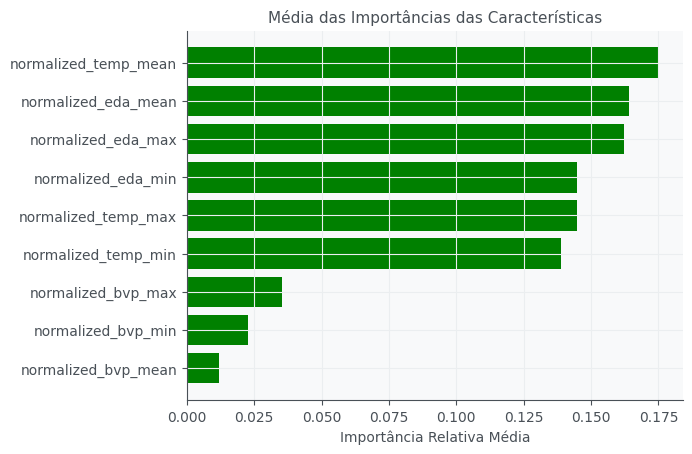

In [34]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Média das Importâncias das Características')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Importância Relativa Média')
plt.show()